## Building a CNN to classify images in the CIFAR-10 Dataset

We will work with the CIFAR-10 Dataset.  This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are:

<ol start="0">
<li> airplane
<li>  automobile
<li> bird
<li>  cat
<li> deer
<li> dog
<li>  frog
<li>  horse
<li>  ship
<li>  truck
</ol>

For details about CIFAR-10 see:
https://www.cs.toronto.edu/~kriz/cifar.html

For a compilation of published performance results on CIFAR 10, see:
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

---

### Building Convolutional Neural Nets

In this exercise we will build and train our first convolutional neural networks.  In the first part, we walk through the different layers and how they are configured.  In the second part, you will build your own model, train it, and compare the performance.

In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
from __future__ import print_function
import random, numpy as np
import keras, tensorflow as tf

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def set_seed(seed_value=1234):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
## Each image is a 32 x 32 x 3 numpy array
x_train[444].shape, x_train[444].dtype 

((32, 32, 3), dtype('uint8'))

[9] truck


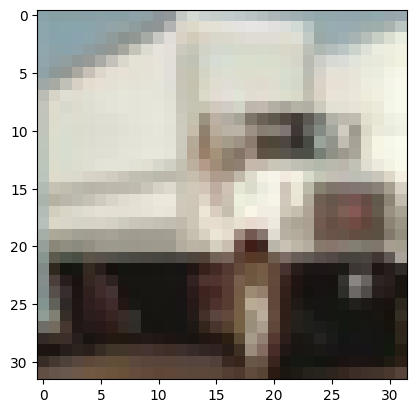

In [7]:
## Let's look at one of the images

image_no = 444
print(y_train[image_no], class_names[y_train[image_no][0]])
plt.imshow(x_train[image_no]);

In [8]:
num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [9]:
# now instead of classes described by an integer between 0-9 we have a vector with a 1 in the (Pythonic) 9th position
y_train[444]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [10]:
# As before, let's make everything float and scale
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

## Keras Layers for CNNs
- Previously we built Neural Networks using primarily the Dense, Activation and Dropout Layers.

- Here we will describe how to use some of the CNN-specific layers provided by Keras

### Conv2D

```python
keras.layers.convolutional.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
```

A few parameters explained:
- `filters`: the number of filter used per location.  In other words, the depth of the output.
- `kernel_size`: an (x,y) tuple giving the height and width of the kernel to be used
- `strides`: and (x,y) tuple giving the stride in each dimension.  Default is `(1,1)`
- `input_shape`: required only for the first layer

Note, the size of the output will be determined by the kernel_size, strides

### MaxPooling2D
`keras.layers.pooling.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)`

- `pool_size`: the (x,y) size of the grid to be pooled.
- `strides`: Assumed to be the `pool_size` unless otherwise specified

### Flatten
Turns its input into a one-dimensional vector (per instance).  Usually used when transitioning between convolutional layers and fully connected layers.

---

## First CNN
Below we will build our first CNN.  For demonstration purposes (so that it will train quickly) it is not very deep and has relatively few parameters.  We use strides of 2 in the first two convolutional layers which quickly reduces the dimensions of the output.  After a MaxPooling layer, we flatten, and then have a single fully connected layer before our final classification layer.

In [11]:
set_seed(12345)

# Let's build a CNN using Keras' Sequential capabilities
model_1 = Sequential()


## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                 input_shape=x_train.shape[1:], activation='relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(2, 2), activation='relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))

## Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes, activation='softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 32)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 512)               147968    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

We still have 181K parameters, even though this is a "small" model.


In [12]:
batch_size = 32

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0005)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history_1 = model_1.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_test, y_test),
                        shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.6718 - accuracy: 0.3935 - val_loss: 1.4824 - val_accuracy: 0.4733
Epoch 2/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.3685 - accuracy: 0.5095 - val_loss: 1.2656 - val_accuracy: 0.5532
Epoch 3/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.2450 - accuracy: 0.5580 - val_loss: 1.1737 - val_accuracy: 0.5853
Epoch 4/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.1658 - accuracy: 0.5880 - val_loss: 1.2268 - val_accuracy: 0.5688
Epoch 5/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.1059 - accuracy: 0.6130 - val_loss: 1.1256 - val_accuracy: 0.6046
Epoch 6/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.0650 - accuracy: 0.6277 - val_loss: 1.1055 - val_accuracy: 0.6149
Epoch 7/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.0317 - accuracy: 0.6397 - val_loss: 1.1145 - val_accuracy:

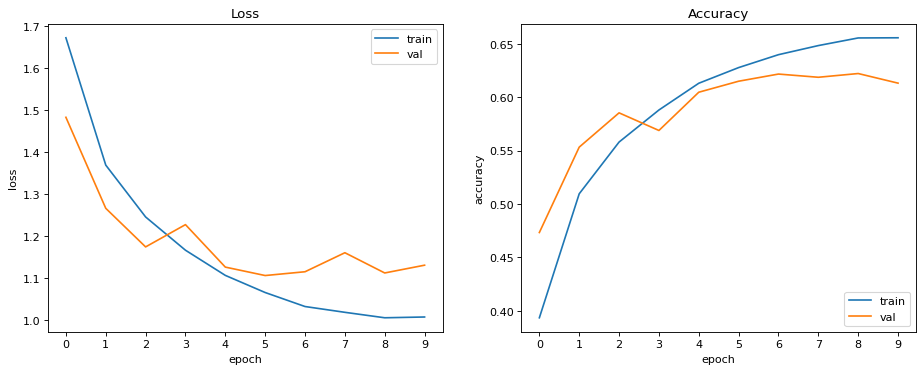

In [13]:
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['loss'])
ax.plot(history_1.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['accuracy'])
ax.plot(history_1.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

### Model Evaluation

In [14]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_test, y_test, verbose=0)))
print()

y_pred = model_1.predict(x_test, verbose=0)

y_test_1d = np.argmax(y_test, axis=1)
y_pred_1d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_1d, y_pred=y_pred_1d).T
print(cm)

Train Loss: 0.953261, Accuracy: 0.672440
 Test Loss: 1.130152, Accuracy: 0.613100

[[771  48 129  50  72  33  33  44 141  59]
 [ 22 757  21  22  11   9  12   6  42 131]
 [ 13   3 382  49  51  56  36  24   1   6]
 [  9   5  42 370  35 178  47  36   4   5]
 [ 17   2 132 102 557  91  49  63   0   8]
 [  1   4  48 107  17 375  19  33   2   3]
 [ 14  12 117 116 103  60 749  12   7  16]
 [ 22   9  70  93 112 127  18 740   7  42]
 [ 96  51  44  60  37  50  27  12 759  59]
 [ 35 109  15  31   5  21  10  30  37 671]]


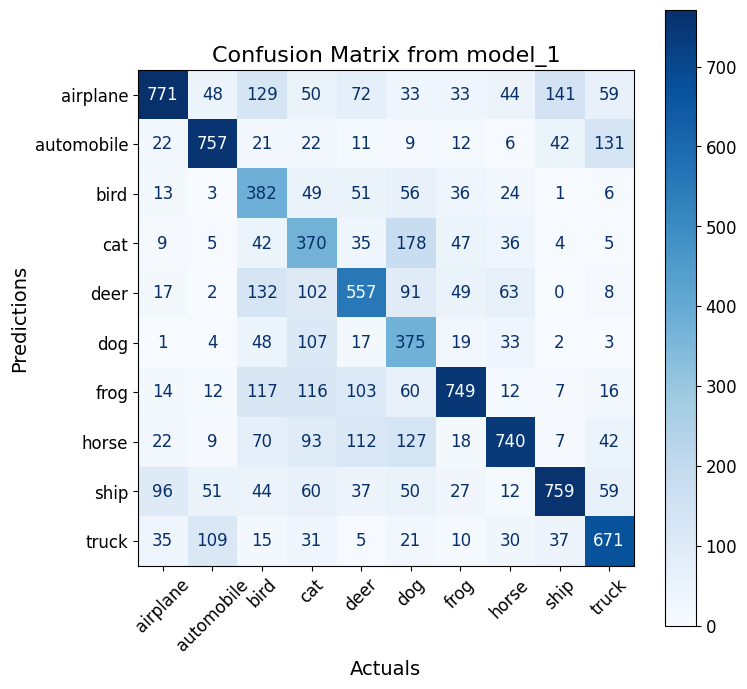

In [15]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)    
plt.title('Confusion Matrix from model_1', fontsize=16)
plt.show()

In [16]:
np.set_printoptions(precision=2)

print(classification_report(y_true=y_test_1d, y_pred=y_pred_1d, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.56      0.77      0.65      1000
  automobile       0.73      0.76      0.74      1000
        bird       0.62      0.38      0.47      1000
         cat       0.51      0.37      0.43      1000
        deer       0.55      0.56      0.55      1000
         dog       0.62      0.38      0.47      1000
        frog       0.62      0.75      0.68      1000
       horse       0.60      0.74      0.66      1000
        ship       0.64      0.76      0.69      1000
       truck       0.70      0.67      0.68      1000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.60     10000
weighted avg       0.61      0.61      0.60     10000



$
\begin{align}
Accuracy &= \frac{TP + TN}{TP + TN + FP + FN} \\
Precision &= \frac{TP}{TP + FP} \\
Recall &= \frac{TP}{TP + FN} \\
F1-Score &= \frac{2}{\frac{1}{Precision} + \frac{1}{Recall}} = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
\end{align}
$

where 
$TP$: True Positives, $TN$: True Negatives, $FP$: False Positives, and $FN$: False Negatives


### <span style="color:blue">แบบฝึกปฏิบัติ</span>
จากโครงสร้างของโมเดลเดิม:

Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

(with appropriate activation functions and dropouts)

1. ให้สร้างโมเดลใหม่ที่มีความซับซ้อนมากขึ้นโดยสามารถใช้รูปแบบโครงสร้างดังนี้:
   - Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

   - ให้ใช้ stride เป็น 1 สำหรับทุกเลเยอร์ convolutional.

2. เทรนโมเดลใหม่โดยใช้เพียง 10 epochs (เท่ากับการเทรนโมเดลเดิม) และอธิบายสิ่งที่สังเกตได้ในเรื่องของเวลา และค่า loss และ accuracy ที่วัดได้จากทั้งชุดข้อมูลเทรนและเทส

3. จากผลการทดสอบโมเดลใหม่ด้วยชุดข้อมูลเทส ให้สร้างกราฟ Confusion Matrix และแสดงรายงาน classification report

4. หาภาพที่โมเดลใหม่ทำนายผิดมาอย่างน้อย 1 ภาพ โดยแสดงภาพให้ปรากฏ แสดงข้อความว่าภาพนั้นเป็นภาพของคลาสอะไร และโมเดลทำนายผิดเป็นคลาสอะไร

In [24]:
set_seed(12345)

model_2 = Sequential([
    Conv2D(32, (5, 5), strides=(1, 1), padding='same',input_shape=x_train.shape[1:], activation='relu'),
    Conv2D(32, (5, 5), strides=(1, 1), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(32, (5, 5), strides=(1, 1), activation='relu'),
    Conv2D(32, (5, 5), strides=(1, 1), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
])

model_2.summary()

batch_size = 32
# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0005)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        2432      
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 10, 10, 32)        25632     
                                                                 
 conv2d_15 (Conv2D)          (None, 6, 6, 32)          25632     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                  

In [25]:


# Let's train the model using RMSprop
model_2.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history_2 = model_2.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_test, y_test),
                        shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.6470 - accuracy: 0.3956 - val_loss: 1.4929 - val_accuracy: 0.4722
Epoch 2/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.2459 - accuracy: 0.5555 - val_loss: 1.1232 - val_accuracy: 0.5970
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0683 - accuracy: 0.6262 - val_loss: 1.0386 - val_accuracy: 0.6347
Epoch 4/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.9590 - accuracy: 0.6647 - val_loss: 1.0566 - val_accuracy: 0.6322
Epoch 5/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.8898 - accuracy: 0.6911 - val_loss: 0.8876 - val_accuracy: 0.6951
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.8411 - accuracy: 0.7101 - val_loss: 0.8974 - val_accuracy: 0.6987
Epoch 7/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.8086 - accuracy: 0.7244 - val_loss: 1.0950 - val_accuracy:

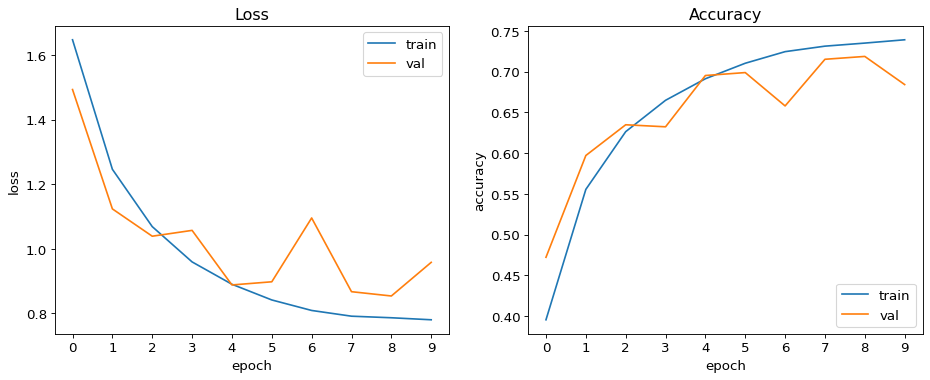

In [26]:
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_2.history['loss'])
ax.plot(history_2.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_2.history['accuracy'])
ax.plot(history_2.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

In [27]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_2.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_2.evaluate(x_test, y_test, verbose=0)))
print()

y_pred = model_2.predict(x_test, verbose=0)

y_test_2d = np.argmax(y_test, axis=1)
y_pred_2d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_2d, y_pred=y_pred_2d).T
print(cm)

Train Loss: 0.744246, Accuracy: 0.742140
 Test Loss: 0.957636, Accuracy: 0.684000

[[647  10  59  11   6   9   4  10  37  15]
 [  7 768   0   1   0   0   1   0  17  41]
 [ 36   0 426  28  22  22  11  16   5   3]
 [ 47  24 108 659 103 310  65 107  39  41]
 [ 61   7 142  62 696  51  36 142  11   4]
 [  5   4  80  98  25 538  10  87   6   1]
 [ 29  40 149 115 117  46 867  26  28  40]
 [ 10   0  20  13  19  17   3 601   0  12]
 [112  29   7   8  11   4   3   2 824  29]
 [ 46 118   9   5   1   3   0   9  33 814]]


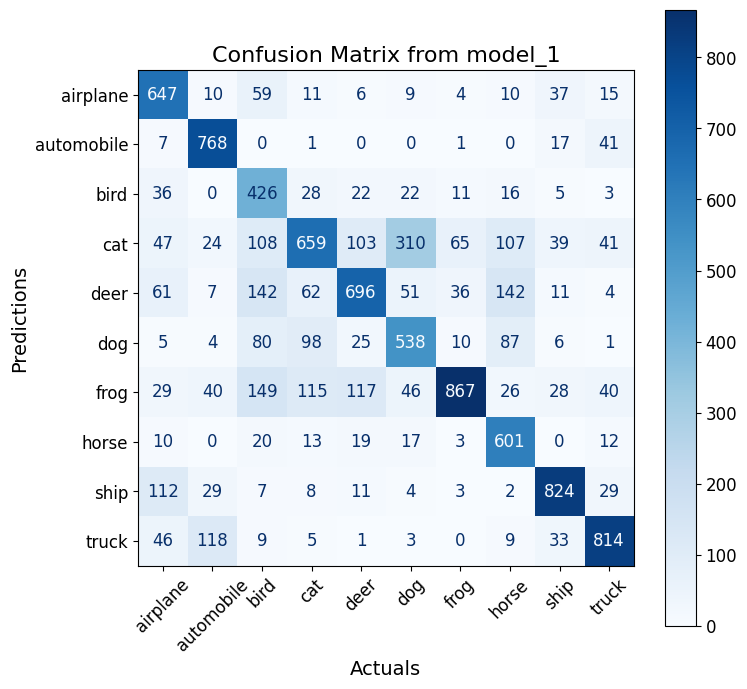

In [28]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)    
plt.title('Confusion Matrix from model_1', fontsize=16)
plt.show()


In [29]:
np.set_printoptions(precision=2)

print(classification_report(y_true=y_test_2d, y_pred=y_pred_2d, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.80      0.65      0.72      1000
  automobile       0.92      0.77      0.84      1000
        bird       0.75      0.43      0.54      1000
         cat       0.44      0.66      0.53      1000
        deer       0.57      0.70      0.63      1000
         dog       0.63      0.54      0.58      1000
        frog       0.60      0.87      0.71      1000
       horse       0.86      0.60      0.71      1000
        ship       0.80      0.82      0.81      1000
       truck       0.78      0.81      0.80      1000

    accuracy                           0.68     10000
   macro avg       0.72      0.68      0.69     10000
weighted avg       0.72      0.68      0.69     10000

